# Developing a toy model for exploring uncertainties in the Pearson correlation coefficient

We want a model framework that produces "climate-like" signals with the following properties:
- ability to dial up/down the serial correlation
- ability to dial up/down the number of ensemble members to produce realistic smoothing
- explore the effect of trends

Things to maybe explore:
- How wrong can the "standard" block-bootstrap approach be?
- How do different significance tests perform?
- What is the effect of ensemble averaging?
- Can we usefully quantify the impact of trends which are often not removed?
- What do the results mean for the signal-to-noise paradox?
- How sensitive are other metrics? e.g MSE?

In [1]:
import numpy as np

import xarray as xr

import xskillscore as xs

import cartopy
import cartopy.crs as ccrs

from xhistogram.xarray import histogram as xhist

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.axes_grid1 import Divider, Size

from src import ar_model, stats, utils

/datasets/work/oa-dcfp/work/squ027/.conda/envs/Squire_2022_correlation/lib/python3.10/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [3]:
DATA_DIR = "../../../Squire_2022_CAFE-f6/data/"

cartopy.config["pre_existing_data_dir"] = f"{DATA_DIR}/cartopy-data"
cartopy.config["data_dir"] = f"{DATA_DIR}/cartopy-data"

In [4]:
plt.rcParams["figure.figsize"] = (12, 6)

## Load some example real signals to explore and replicate

In [5]:
can = xr.open_zarr(
    f"{DATA_DIR}/processed/CanESM5_ctrl.annual.anom_6571-6600.precip_global.zarr"
)
can["t_ref"] = xr.open_zarr(
    f"{DATA_DIR}/processed/CanESM5_ctrl.annual.anom_6571-6600.t_ref_global.zarr"
)["t_ref"]
can["sst"] = xr.open_zarr(
    f"{DATA_DIR}/processed/CanESM5_ctrl.annual.anom_6571-6600.sst_global.zarr"
)["sst"]

ec = xr.open_zarr(
    f"{DATA_DIR}/processed/EC_Earth3_ctrl.annual.anom_2730-2759.precip_global.zarr"
)
ec["t_ref"] = xr.open_zarr(
    f"{DATA_DIR}/processed/EC_Earth3_ctrl.annual.anom_2730-2759.t_ref_global.zarr"
)["t_ref"]
ec["sst"] = xr.open_zarr(
    f"{DATA_DIR}/processed/EC_Earth3_ctrl.annual.anom_2730-2759.sst_global.zarr"
)["sst"]
ec["slp"] = xr.open_zarr(
    f"{DATA_DIR}/processed/EC_Earth3_ctrl.annual.anom_2730-2759.slp_global.zarr"
)["slp"]

## What do the partial autocorrelation functions look like for these fields?

In [6]:
pacf_can = stats.acf(can, partial=True, nlags=3).compute()
pacf_ec = stats.acf(ec, partial=True, nlags=3).compute()

In [7]:
def plot_pacf_lags(pacf, lags, title=None, figsize=None, vrange=(-1, 1)):

    nrows = len(pacf)
    ncols = len(lags)
    if figsize is None:
        figsize = (5.0 * ncols, 2.5 * nrows)

    fig = plt.figure(figsize=figsize)
    axs = fig.subplots(
        nrows,
        ncols,
        sharex=True,
        sharey=True,
        subplot_kw=dict(projection=ccrs.PlateCarree(180)),
    )

    bounds = np.linspace(vrange[0], vrange[1], 21)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=len(bounds) - 1)

    for y, l in enumerate(lags):
        for x, v in enumerate(pacf.keys()):
            ax = axs[x, y]
            p = (
                pacf[v]
                .sel(lag=l)
                .plot(
                    ax=ax,
                    transform=ccrs.PlateCarree(),
                    vmin=vrange[0],
                    vmax=vrange[1],
                    norm=norm,
                    cmap="RdBu_r",
                    add_colorbar=False,
                )
            )
            p.axes.coastlines(color=[0.2, 0.2, 0.2], linewidth=0.75)

            ax.set_title(f"{v} | lag {l}")

    h = [Size.Fixed(figsize[0] / 12), Size.Fixed(figsize[0] - figsize[0] / 6)]
    v = [Size.Fixed(0), Size.Fixed(0.15)]
    divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
    cbar_ax = fig.add_axes(
        divider.get_position(), axes_locator=divider.new_locator(nx=1, ny=1)
    )
    fig.colorbar(p, cax=cbar_ax, orientation="horizontal")

    if title:
        fig.suptitle(title)

    return fig

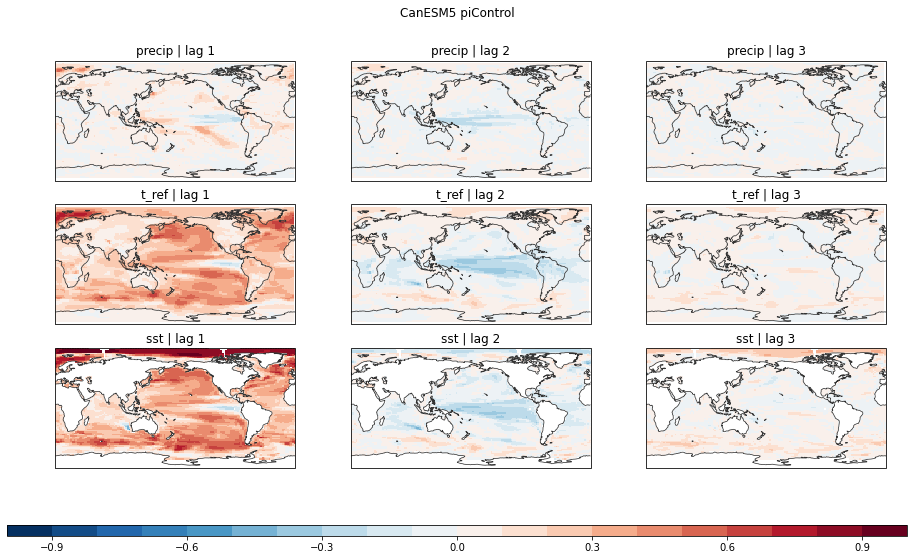

In [8]:
_ = plot_pacf_lags(pacf_can, lags=[1, 2, 3], title="CanESM5 piControl")

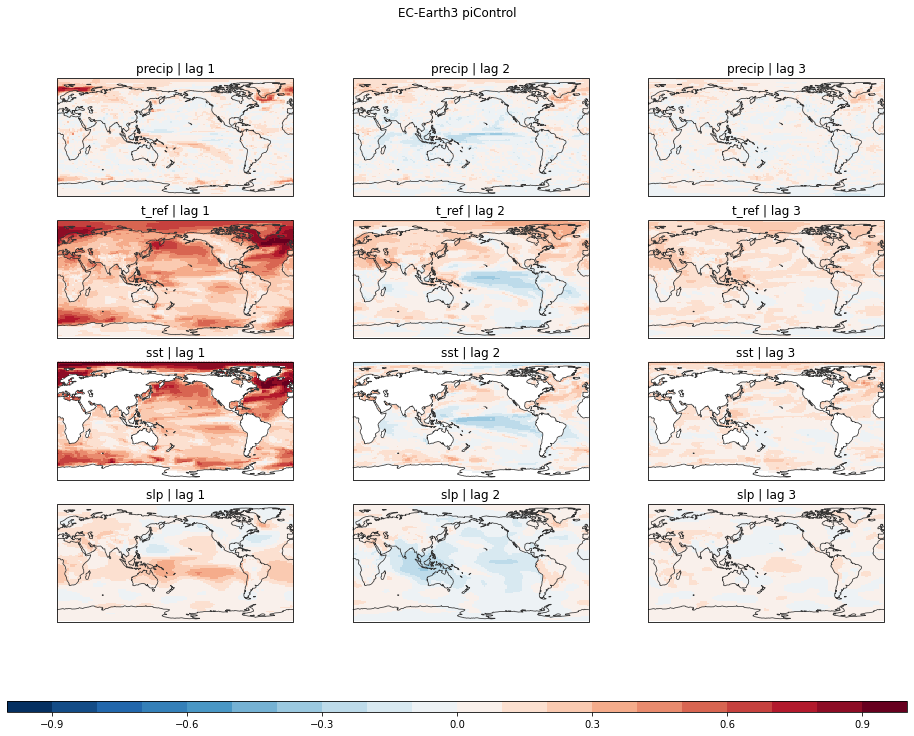

In [9]:
_ = plot_pacf_lags(pacf_ec, lags=[1, 2, 3], title="EC-Earth3 piControl")

## Let's look at how the order 2 coefficient vary across the globe

In [10]:
order = 2

coeffs_can = ar_model.yule_walker(can, order=order).compute()
coeffs_ec = ar_model.yule_walker(ec, order=order).compute()

In [11]:
def plot_coeffs(coeffs, figsize=None):

    ncols = len(coeffs)
    if figsize is None:
        figsize = (5.0 * ncols, 4)

    fig = plt.figure(figsize=figsize)
    axs = fig.subplots(
        1,
        ncols,
        sharex=True,
        sharey=True,
    )

    for i, v in enumerate(coeffs.keys()):
        ax = axs[i]
        p = ax.scatter(
            coeffs[v].sel(coeff=1),
            coeffs[v].sel(coeff=2),
            s=10,
            c=coeffs[v].sel(coeff=0),
        )
        ax.set_xlabel(r"$\phi_{1}$")
        ax.set_ylabel(r"$\phi_{2}$")
        ax.set_title(v)
        ax.grid()

    h = [Size.Fixed(figsize[0] / 12), Size.Fixed(figsize[0] - figsize[0] / 6)]
    v = [Size.Fixed(-0.3), Size.Fixed(0.15)]
    divider = Divider(fig, (0, 0, 1, 1), h, v, aspect=False)
    cbar_ax = fig.add_axes(
        divider.get_position(), axes_locator=divider.new_locator(nx=1, ny=1)
    )
    fig.colorbar(p, cax=cbar_ax, orientation="horizontal", label=r"$\sigma_{\epsilon}$")

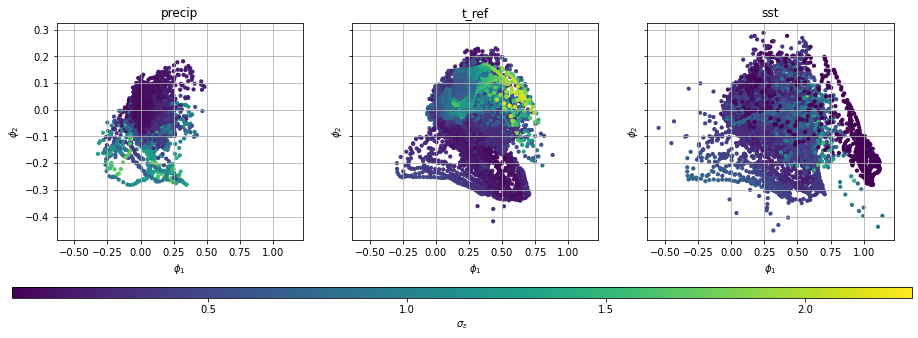

In [12]:
plot_coeffs(coeffs_can)

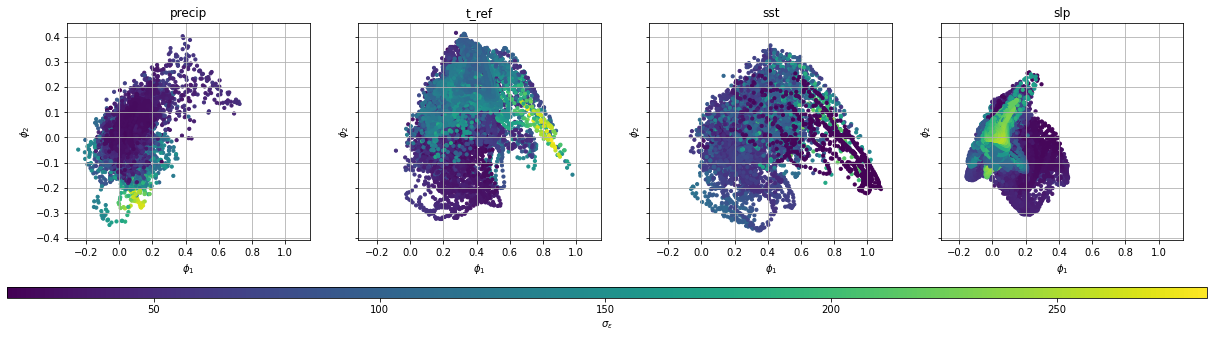

In [13]:
plot_coeffs(coeffs_ec)

# What about coming up with some example cases with similar ACFs to, for example:
- **s1**: highly correlated sst index (e.g. box over Atlantic subpolar gyre - https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2020GL091307, https://link.springer.com/article/10.1007/s00382-014-2212-7)
- **s2**: nao index (e.g. https://www.nature.com/articles/s41612-019-0071-y)
- **s3**: "independent" precip index (e.g. box over Australia)

In [162]:
n_times = 50
n_samples = 1000
n_members = 40
rolling_means = [2, 4, 8]

## **s1**: Atlantic subpolar gyre

-------------------

In [163]:
spg = utils.detrend(
    utils.extract_subpolar_gyre_region(ec["sst"]),
)

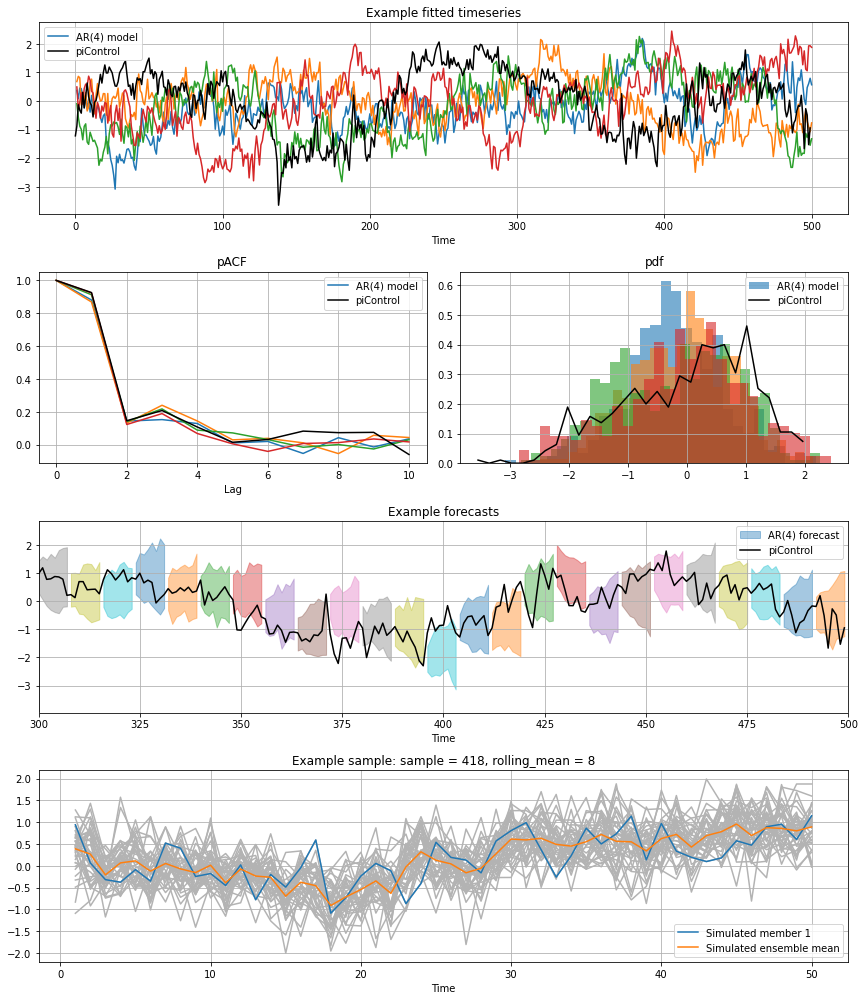

In [164]:
s1_fcst = ar_model.generate_samples_like(
    spg,
    order="select_order",
    n_times=n_times,
    n_samples=n_samples,
    n_members=n_members,
    rolling_means=rolling_means,
    plot_diagnostics=True,
)

s1_obsv = ar_model.generate_samples_like(
    spg,
    order="select_order",
    n_times=n_times,
    n_samples=n_samples,
    rolling_means=rolling_means,
    plot_diagnostics=False,
)

## **s2**: NAO index

-------------------

In [165]:
nao = utils.calculate_NAO_index(ec["slp"]) / 100

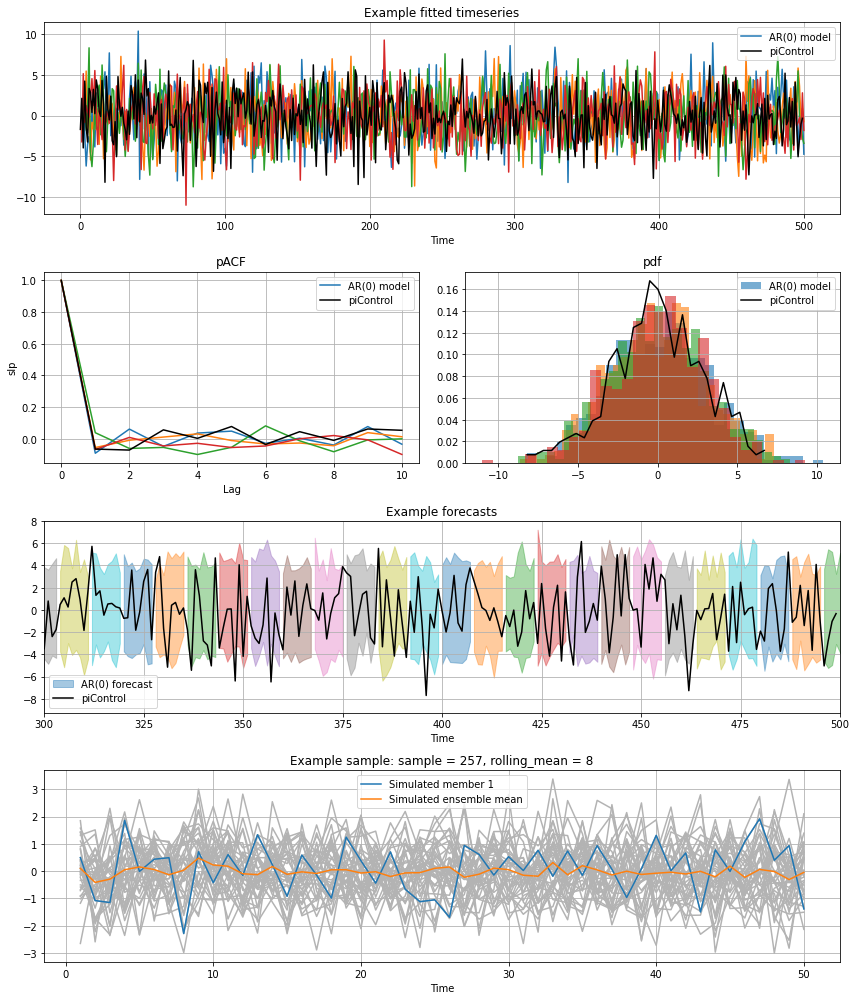

In [166]:
s2_fcst = ar_model.generate_samples_like(
    nao,
    order="select_order",
    n_times=n_times,
    n_samples=n_samples,
    n_members=n_members,
    rolling_means=rolling_means,
    plot_diagnostics=True,
)

s2_obsv = ar_model.generate_samples_like(
    nao,
    order="select_order",
    n_times=n_times,
    n_samples=n_samples,
    rolling_means=rolling_means,
    plot_diagnostics=False,
)

## **s3**: Precipitation over Australia

-------------------

In [167]:
AUS_box = [112, 155, -44, -11]
aus = utils.extract_lon_lat_box(ec["precip"], AUS_box, weighted_average=True)

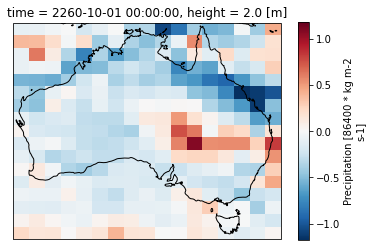

In [168]:
p = (
    utils.extract_lon_lat_box(ec["precip"], AUS_box, weighted_average=False)
    .isel(time=0)
    .plot(
        subplot_kws=dict(projection=ccrs.PlateCarree(), facecolor="gray"),
        transform=ccrs.PlateCarree(),
    )
)
_ = p.axes.coastlines()

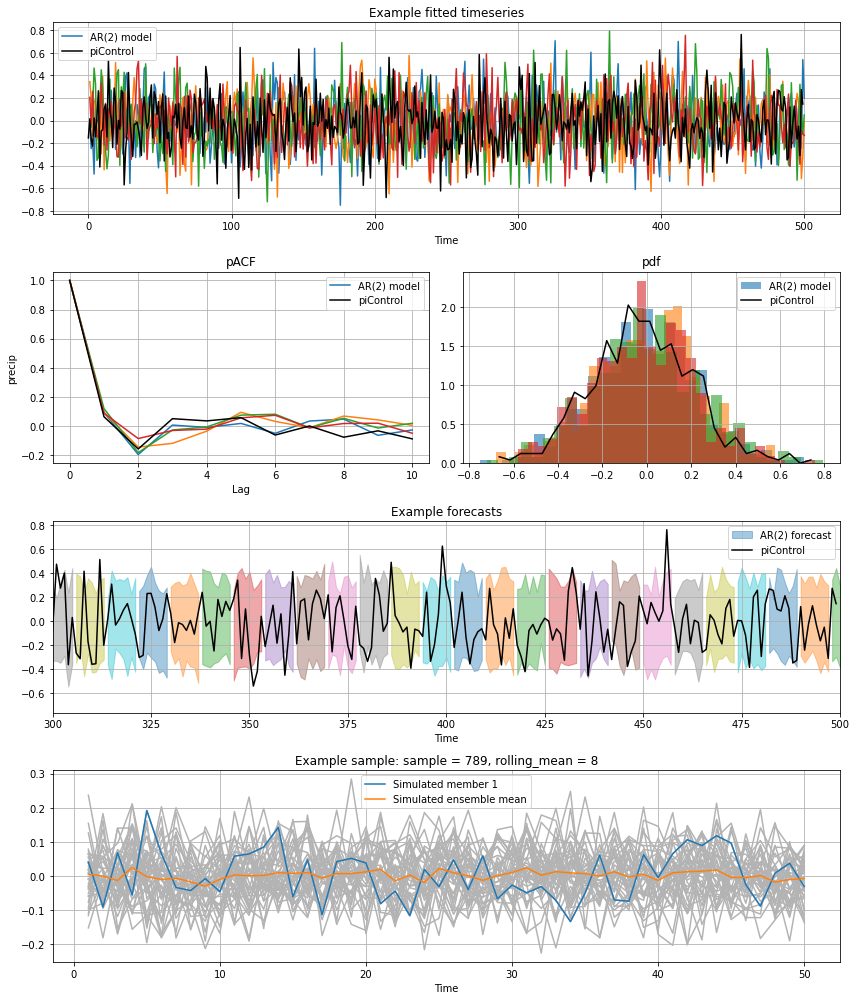

In [169]:
s3_fcst = ar_model.generate_samples_like(
    aus,
    order="select_order",
    n_times=n_times,
    n_samples=n_samples,
    n_members=n_members,
    rolling_means=rolling_means,
    plot_diagnostics=True,
)

s3_obsv = ar_model.generate_samples_like(
    aus,
    order="select_order",
    n_times=n_times,
    n_samples=n_samples,
    rolling_means=rolling_means,
    plot_diagnostics=False,
)

## How to visualise sentivities?

Let's calculate the Type I error rates (i.e. the proportion of samples that reject the null hypothesis when it's actually true) for $\alpha = 0.05$ using various methods for inference

Parameters:
- Sample length (length of `time`)
- Temporal averaging (`rolling_mean`)
- Number of ensemble members (length of `member`)

In [172]:
%%time

s1_r, s1_pval = stats.infer_metric(
    s1_fcst.sel(time=slice(0,30)),
    s1_obsv.sel(time=slice(0,30)),
    metric="pearson_r",
    method="bootstrap",
    method_kwargs=dict(
        blocks={"time": 5, "member": 1}, n_permutations=500, transform="Fisher_z"
    ),
)

CPU times: user 6.35 s, sys: 4.46 s, total: 10.8 s
Wall time: 10.5 s


In [173]:
(s1_pval < 0.05).mean("sample")

<xarray.DataArray (rolling_mean: 4)>
array([0.257, 0.266, 0.3  , 0.329])
Coordinates:
  * rolling_mean  (rolling_mean) int64 1 2 4 8

In [171]:
(s1_pval < 0.05).mean("sample")

<xarray.DataArray (rolling_mean: 4)>
array([0.289, 0.301, 0.327, 0.38 ])
Coordinates:
  * rolling_mean  (rolling_mean) int64 1 2 4 8

<xarray.DataArray ()>
array(-0.02837929)
Coordinates:
    sample        int64 4
    rolling_mean  int64 1

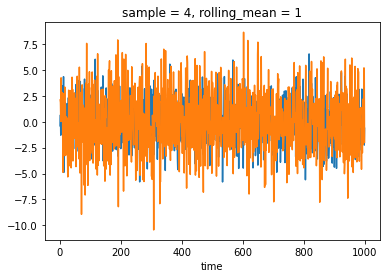

In [135]:
sample = 4
s2_fcst.sel(rolling_mean=1, sample=sample).mean("member").plot()
s2_obsv.sel(rolling_mean=1, sample=sample).plot()

s2_r.sel(rolling_mean=1, sample=sample)

<xarray.DataArray ()>
array(-0.2654265)
Coordinates:
    sample        int64 0
    rolling_mean  int64 1

In [70]:
xs.pearson_r(
    s1_fcst.sel(time=slice(0, 50)).mean("member"),
    s1_obsv.sel(time=slice(0, 50)),
    dim="time",
)

<xarray.DataArray (rolling_mean: 4, sample: 1000)>
array([[ 0.05227125, -0.05675827,  0.25323855, ...,  0.40716033,
        -0.30391336, -0.12002682],
       [ 0.08490647, -0.10690108,  0.28115401, ...,  0.46072523,
        -0.36406332, -0.11800276],
       [ 0.2648627 , -0.27290729,  0.31552117, ...,  0.53350036,
        -0.47725791, -0.11956483],
       [ 0.43269601, -0.41579776,  0.29731749, ...,  0.40082893,
        -0.65310911, -0.08157254]])
Coordinates:
  * sample        (sample) int64 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * rolling_mean  (rolling_mean) int64 1 2 4 8

(array([ 30.,  74., 138., 141., 146., 147., 136., 104.,  71.,  13.]),
 array([-0.84458454, -0.66946955, -0.49435455, -0.31923956, -0.14412456,
         0.03099043,  0.20610543,  0.38122043,  0.55633542,  0.73145042,
         0.90656541]),
 <BarContainer object of 10 artists>)

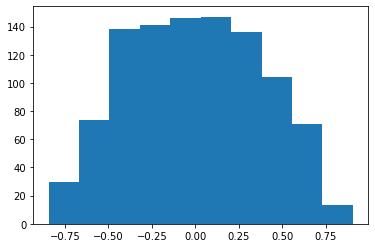

In [72]:
plt.hist(s1_r.isel(rolling_mean=0))

(array([ 17.,  63., 128., 135., 160., 155., 146., 109.,  73.,  14.]),
 array([-8.53915758e-01, -6.83281129e-01, -5.12646499e-01, -3.42011870e-01,
        -1.71377240e-01, -7.42610543e-04,  1.69892019e-01,  3.40526649e-01,
         5.11161278e-01,  6.81795908e-01,  8.52430537e-01]),
 <BarContainer object of 10 artists>)

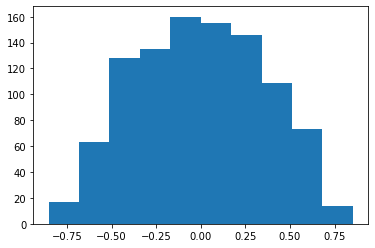

In [69]:
plt.hist(s1_r.isel(rolling_mean=0))

In [53]:
(s1_pval < 0.05).mean("sample")

<xarray.DataArray (rolling_mean: 4)>
array([0.357, 0.373, 0.385, 0.397])
Coordinates:
  * rolling_mean  (rolling_mean) int64 1 2 4 8

In [23]:
(s1_pval < 0.05).mean("sample")

<xarray.DataArray (rolling_mean: 4)>
array([0.429, 0.435, 0.459, 0.462])
Coordinates:
  * rolling_mean  (rolling_mean) int64 1 2 4 8

In [23]:
(s1_pval < 0.05).mean("sample")

<xarray.DataArray (rolling_mean: 4)>
array([0.318, 0.327, 0.333, 0.354])
Coordinates:
  * rolling_mean  (rolling_mean) int64 1 2 4 8

### Let's brute force the bootstrapping to be sure our code is working

In [44]:
def _random_blocks(length, block):
    """
    Indices to randomly sample blocks in a cyclic manner along an axis of a
    specified length
    """

    import math
    from itertools import chain, islice, cycle

    if block == length:
        return list(range(length))
    else:
        repeats = math.ceil(length / block)
        return list(
            chain.from_iterable(
                islice(cycle(range(length)), s, s + block)
                for s in np.random.randint(0, length, repeats)
            )
        )[:length]

[53, 54, 55, 56, 57, 80, 81, 82, 83, 84, 3, 4, 5, 6, 7, 33, 34, 35, 36, 37, 78, 79, 80, 81, 82, 54, 55, 56, 57, 58, 54, 55, 56, 57, 58, 16, 17, 18, 19, 20, 40, 41, 42, 43, 44, 23, 24, 25, 26, 27, 52, 53, 54, 55, 56, 71, 72, 73, 74, 75, 29, 30, 31, 32, 33, 85, 86, 87, 88, 89, 53, 54, 55, 56, 57, 70, 71, 72, 73, 74, 12, 13, 14, 15, 16, 98, 99, 0, 1, 2, 30, 31, 32, 33, 34, 55, 56, 57, 58, 59]


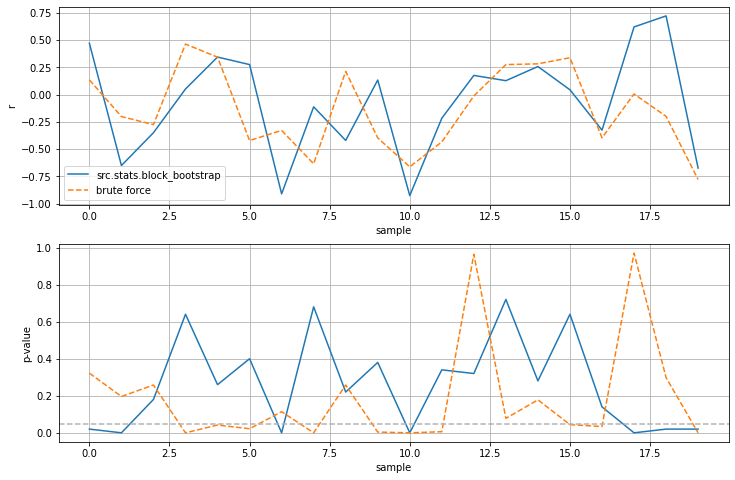

In [45]:
from scipy.stats import pearsonr

rolling_mean = 8
samples = 20
n_permutations = 1000
block = 5

brute_r = np.empty(samples)
r_bs = np.empty((samples, n_permutations))

print_example = True
for samp in range(samples):
    a = s1_fcst.sel(rolling_mean=rolling_mean, sample=samp).values
    b = s1_obsv.sel(rolling_mean=rolling_mean, sample=samp).values

    brute_r[samp], _ = pearsonr(np.mean(a, axis=0), b)

    for p in range(n_permutations):
        random_time_indices = _random_blocks(a.shape[-1], block)
        if print_example:
            print(random_time_indices)
            print_example = False
        a_p = a[:, random_time_indices]
        for t_start in range(0, a.shape[-1], block):
            random_ensemble_indices = np.random.randint(0, a.shape[0], size=a.shape[0])
            a_p[:, t_start : t_start + block] = a_p[
                random_ensemble_indices, t_start : t_start + block
            ]
        a_p = np.mean(a_p, axis=0)
        b_p = b[random_time_indices]

        r_bs[samp, p], _ = pearsonr(a_p, b_p)

left = (r_bs < 0).mean(axis=-1) * 2
right = (r_bs > 0).mean(axis=-1) * 2
brute_pval = np.where(brute_r > 0, left, right)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(2, 1, 1)
s1_r.sel(rolling_mean=rolling_mean, sample=range(samples)).plot(
    label="src.stats.block_bootstrap"
)
ax.plot(brute_r, linestyle="--", label="brute force")
ax.set_ylabel("r")
ax.set_title("")
ax.legend()
ax.grid()

ax = fig.add_subplot(2, 1, 2)
s1_pval.sel(rolling_mean=rolling_mean, sample=range(samples)).plot(
    label="src.stats.block_bootstrap"
)
ax.plot(brute_pval, linestyle="--", label="brute force")
ax.set_ylabel("p-value")
ax.set_title("")
ax.grid()
xlim = ax.get_xlim()
ax.plot(xlim, [0.05, 0.05], color=[0.7, 0.7, 0.7], linestyle="--")
_ = ax.set_xlim(xlim)